# DSA 2040 Practical Exam - Section 1: Data Warehousing

**Student Name:** Arnold Bophine Odiyo  
**Student ID:** 821  
**Date:** December 11, 2025

---

## Overview

This notebook demonstrates the complete **ETL (Extract, Transform, Load)** pipeline for building a Data Warehouse using a **Star Schema** design. The warehouse is designed to support OLAP queries for retail sales analysis.

### Objectives:
1. **Extract** data from the Online Retail CSV dataset
2. **Transform** the data (clean, calculate metrics, simulate current dates)
3. **Load** data into an SQLite Data Warehouse
4. **Visualize** insights from the warehouse

## 1. Import Required Libraries

We'll use:
- `pandas` for data manipulation
- `sqlite3` for database operations
- `matplotlib` and `seaborn` for visualizations

In [44]:
# Get current working directory
CURRENT_DIR = os.getcwd()

# Determine project root
# If we're in DataWarehousing folder, go up one level
if os.path.basename(CURRENT_DIR) == 'DataWarehousing':
    BASE_DIR = os.path.dirname(CURRENT_DIR)
else:
    BASE_DIR = CURRENT_DIR

# Define file paths
DATA_FILE = os.path.join(BASE_DIR, 'Copy of Online Retail.csv')
DB_FILE = os.path.join(BASE_DIR, 'DataWarehousing', 'retail_dw.db')
SCHEMA_FILE = os.path.join(BASE_DIR, 'DataWarehousing', 'warehouse_schema.sql')

print(f"Current Directory: {CURRENT_DIR}")
print(f"Project Root: {BASE_DIR}")
print(f"\nFile Paths:")
print(f"  Data CSV: {DATA_FILE}")
print(f"  Database: {DB_FILE}")
print(f"  Schema: {SCHEMA_FILE}")
print(f"\nFile Exists:")
print(f"  ✓ Data CSV: {os.path.exists(DATA_FILE)}")
print(f"  ✓ Schema SQL: {os.path.exists(SCHEMA_FILE)}")

Current Directory: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\DataWarehousing
Project Root: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821

File Paths:
  Data CSV: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\Copy of Online Retail.csv
  Database: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\DataWarehousing\retail_dw.db
  Schema: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\DataWarehousing\warehouse_schema.sql

File Exists:
  ✓ Data CSV: True
  ✓ Schema SQL: True


def init_db():
    """Initialize the database with schema."""
    print("Initializing Database...")
    
    # Close any existing connections first
    import gc
    gc.collect()  # Force garbage collection to close any lingering connections
    
    if os.path.exists(DB_FILE):
        try:
            os.remove(DB_FILE)
            print("Removed existing database file.")
        except PermissionError:
            print("⚠ Database file is in use. Skipping deletion (will use existing database).")
            print("  If you need a fresh database, restart the kernel and run again.")
            return
    
    try:
        with open(SCHEMA_FILE, 'r') as f:
            schema_sql = f.read()
        
        conn = sqlite3.connect(DB_FILE)
        cursor = conn.cursor()
        cursor.executescript(schema_sql)
        conn.commit()
        conn.close()
        print("✓ Database initialized successfully.")
    except Exception as e:
        print(f"✗ Error initializing DB: {e}")

# Execute initialization
init_db()

In [45]:
# Get current working directory
CURRENT_DIR = os.getcwd()

# Determine project root
# If we're in DataWarehousing folder, go up one level
if os.path.basename(CURRENT_DIR) == 'DataWarehousing':
    BASE_DIR = os.path.dirname(CURRENT_DIR)
else:
    BASE_DIR = CURRENT_DIR

# Define file paths
DATA_FILE = os.path.join(BASE_DIR, 'Copy of Online Retail.csv')
DB_FILE = os.path.join(BASE_DIR, 'DataWarehousing', 'retail_dw.db')
SCHEMA_FILE = os.path.join(BASE_DIR, 'DataWarehousing', 'warehouse_schema.sql')

print(f"Current Directory: {CURRENT_DIR}")
print(f"Project Root: {BASE_DIR}")
print(f"\nFile Paths:")
print(f"  Data CSV: {DATA_FILE}")
print(f"  Database: {DB_FILE}")
print(f"  Schema: {SCHEMA_FILE}")
print(f"\nFile Exists:")
print(f"  ✓ Data CSV: {os.path.exists(DATA_FILE)}")
print(f"  ✓ Schema SQL: {os.path.exists(SCHEMA_FILE)}")

Current Directory: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\DataWarehousing
Project Root: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821

File Paths:
  Data CSV: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\Copy of Online Retail.csv
  Database: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\DataWarehousing\retail_dw.db
  Schema: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\DataWarehousing\warehouse_schema.sql

File Exists:
  ✓ Data CSV: True
  ✓ Schema SQL: True


## 3. Initialize Database

This function:
- Removes any existing database (for fresh start)
- Reads the Star Schema SQL definition
- Creates tables: `CustomerDim`, `ProductDim`, `TimeDim`, and `SalesFact`

In [46]:
def init_db():
    """Initialize the database with schema."""
    print("Initializing Database...")
    
    # Close any existing connections first
    import gc
    gc.collect()  # Force garbage collection to close any lingering connections
    
    if os.path.exists(DB_FILE):
        try:
            os.remove(DB_FILE)
            print("Removed existing database file.")
        except PermissionError:
            print("⚠ Database file is in use. Skipping deletion (will use existing database).")
            print("  If you need a fresh database, restart the kernel and run again.")
            return
    
    try:
        with open(SCHEMA_FILE, 'r') as f:
            schema_sql = f.read()
        
        conn = sqlite3.connect(DB_FILE)
        cursor = conn.cursor()
        cursor.executescript(schema_sql)
        conn.commit()
        conn.close()
        print("✓ Database initialized successfully.")
    except Exception as e:
        print(f"✗ Error initializing DB: {e}")

# Execute initialization
init_db()

Initializing Database...
⚠ Database file is in use. Skipping deletion (will use existing database).
  If you need a fresh database, restart the kernel and run again.


## 4. EXTRACT Phase

**Goal:** Load raw data from the CSV file.

**Challenges:**
- The dataset may have encoding issues (common in legacy systems)
- We handle this by trying multiple encodings

**Expected Output:** ~541,000 raw transaction records

In [47]:
def extract_data(file_path):
    """Task 2.2: Extract Phase"""
    print(f"\n--- EXTRACT PHASE ---")
    print(f"Reading data from: {file_path}")
    try:
        try:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='utf-8')
            
        print(f"✓ Extracted {len(df):,} rows.")
        print(f"\nColumns: {list(df.columns)}")
        return df
    except Exception as e:
        print(f"✗ Error extraction: {e}")
        return None

# Execute extraction
df_raw = extract_data(DATA_FILE)

# Display sample
if df_raw is not None:
    print("\nSample Data:")
    display(df_raw.head())
    print(f"\nData Types:\n{df_raw.dtypes}")


--- EXTRACT PHASE ---
Reading data from: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\Copy of Online Retail.csv
✓ Extracted 541,909 rows.

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Sample Data:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



Data Types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


## 5. TRANSFORM Phase

This is the most complex phase with multiple operations:

### 5.1 Data Cleaning
- Remove rows with missing `CustomerID` (can't link to customer dimension)
- Filter out invalid transactions (negative quantities, zero prices)

### 5.2 Feature Engineering
- Calculate `TotalSales = Quantity × UnitPrice`

### 5.3 Date Simulation
- Original data is from 2010-2011
- Shift all dates to 2024-2025 to simulate current data
- Filter to last 12 months (Aug 2024 - Aug 2025)

### 5.4 Dimension Extraction
- Extract unique customers → `CustomerDim`
- Extract unique products → `ProductDim`
- Extract unique dates with time attributes → `TimeDim`

In [48]:
def transform_data(df):
    """Task 2.3: Transform Phase"""
    print(f"\n--- TRANSFORM PHASE ---")
    initial_count = len(df)
    
    # 1. Drop missing CustomerID
    print("\n[1/6] Dropping rows with missing CustomerID...")
    df = df.dropna(subset=['CustomerID']).copy()
    print(f"  Rows after cleaning: {len(df):,} (Dropped {initial_count - len(df):,})")
    
    # 2. Convert types
    print("\n[2/6] Converting data types...")
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['CustomerID'] = df['CustomerID'].astype(int)
    print("  ✓ Dates and IDs converted")
    
    # 3. Calculate TotalSales
    print("\n[3/6] Calculating TotalSales...")
    df['TotalSales'] = df['Quantity'] * df['UnitPrice']
    print(f"  ✓ TotalSales calculated (Sample: ${df['TotalSales'].iloc[0]:.2f})")
    
    # 4. Simulate 2025 Data (Date Shifting)
    print("\n[4/6] Simulating 2024-2025 Data: Shifting dates...")
    max_date = df['InvoiceDate'].max()
    target_date = pd.Timestamp('2025-08-12')
    time_delta = target_date - max_date
    
    df['InvoiceDate'] = df['InvoiceDate'] + time_delta
    print(f"  Original max date: {max_date.date()}")
    print(f"  New date range: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")
    
    # Filter for last year
    start_date = target_date - pd.DateOffset(years=1)
    df = df[(df['InvoiceDate'] >= start_date) & (df['InvoiceDate'] <= target_date)]
    
    # Remove invalid transactions
    print("\n[5/6] Filtering invalid quantities and prices...")
    df = df[df['Quantity'] > 0]
    df = df[df['UnitPrice'] > 0]
    print(f"  ✓ Rows after filtering: {len(df):,}")
    
    # 5. Extract Dimensions
    print("\n[6/6] Extracting Dimensions...")
    
    # Customer Dimension
    customer_dim = df.groupby('CustomerID').agg({
        'Country': 'first'
    }).reset_index()
    customer_dim.columns = ['customer_id', 'country']
    customer_dim['source_customer_id'] = customer_dim['customer_id'].astype(str)
    customer_dim['name'] = 'Customer ' + customer_dim['source_customer_id']
    print(f"  ✓ CustomerDim: {len(customer_dim):,} unique customers")
    
    # Time Dimension
    unique_dates = df['InvoiceDate'].dt.date.unique()
    time_dim = pd.DataFrame({'full_date': unique_dates})
    time_dim['full_date'] = pd.to_datetime(time_dim['full_date'])
    time_dim['time_id'] = time_dim['full_date'].dt.strftime('%Y%m%d').astype(int)
    time_dim['day'] = time_dim['full_date'].dt.day
    time_dim['month'] = time_dim['full_date'].dt.month
    time_dim['year'] = time_dim['full_date'].dt.year
    time_dim['quarter'] = time_dim['full_date'].dt.quarter
    time_dim['day_of_week'] = time_dim['full_date'].dt.day_name()
    print(f"  ✓ TimeDim: {len(time_dim):,} unique dates")
    
    # Product Dimension
    product_dim = df.groupby('StockCode').agg({
        'Description': 'first'
    }).reset_index()
    product_dim.columns = ['stock_code', 'description']
    product_dim['product_id'] = product_dim.index + 1
    product_dim['category'] = 'General'
    print(f"  ✓ ProductDim: {len(product_dim):,} unique products")
    
    # Prepare Sales Fact
    print("\nPreparing Sales Fact Table...")
    fact_table = df.merge(product_dim[['stock_code', 'product_id']], 
                          left_on='StockCode', right_on='stock_code', how='left')
    fact_table['time_id'] = fact_table['InvoiceDate'].dt.strftime('%Y%m%d').astype(int)
    
    sales_fact = fact_table[[
        'CustomerID', 'product_id', 'time_id', 'InvoiceNo', 'Quantity', 'UnitPrice', 'TotalSales'
    ]].copy()
    sales_fact.columns = ['customer_id', 'product_id', 'time_id', 'invoice_no', 
                          'quantity', 'unit_price', 'total_sales']
    print(f"  ✓ SalesFact: {len(sales_fact):,} transactions")
    
    return {
        'CustomerDim': customer_dim,
        'ProductDim': product_dim,
        'TimeDim': time_dim,
        'SalesFact': sales_fact
    }

# Execute transformation
if df_raw is not None:
    data_staging = transform_data(df_raw)
    
    # Display samples from each dimension
    print("\n" + "="*60)
    print("TRANSFORMATION COMPLETE - Sample Data:")
    print("="*60)
    
    print("\nCustomerDim Sample:")
    display(data_staging['CustomerDim'].head())
    
    print("\nProductDim Sample:")
    display(data_staging['ProductDim'].head())
    
    print("\nTimeDim Sample:")
    display(data_staging['TimeDim'].head())
    
    print("\nSalesFact Sample:")
    display(data_staging['SalesFact'].head())


--- TRANSFORM PHASE ---

[1/6] Dropping rows with missing CustomerID...
  Rows after cleaning: 406,829 (Dropped 135,080)

[2/6] Converting data types...
  ✓ Dates and IDs converted

[3/6] Calculating TotalSales...
  ✓ TotalSales calculated (Sample: $15.30)

[4/6] Simulating 2024-2025 Data: Shifting dates...
  Original max date: 2011-12-09
  New date range: 2024-08-03 to 2025-08-12

[5/6] Filtering invalid quantities and prices...
  ✓ Rows after filtering: 384,529

[6/6] Extracting Dimensions...
  ✓ CustomerDim: 4,269 unique customers
  ✓ TimeDim: 352 unique dates
  ✓ ProductDim: 3,630 unique products

Preparing Sales Fact Table...
  ✓ SalesFact: 384,529 transactions

TRANSFORMATION COMPLETE - Sample Data:

CustomerDim Sample:


,customer_id,country,source_customer_id,name
0,12346,United Kingdom,12346,Customer 12346
1,12347,Iceland,12347,Customer 12347
2,12348,Finland,12348,Customer 12348
3,12349,Italy,12349,Customer 12349
4,12350,Norway,12350,Customer 12350



ProductDim Sample:


,stock_code,description,product_id,category
0,10002,INFLATABLE POLITICAL GLOBE,1,General
1,10080,GROOVY CACTUS INFLATABLE,2,General
2,10120,DOGGY RUBBER,3,General
3,10123C,HEARTS WRAPPING TAPE,4,General
4,10124A,SPOTS ON RED BOOKCOVER TAPE,5,General



TimeDim Sample:


,full_date,time_id,day,month,year,quarter,day_of_week
0,2024-08-12,20240812,12,8,2024,3,Monday
1,2024-08-13,20240813,13,8,2024,3,Tuesday
2,2024-08-14,20240814,14,8,2024,3,Wednesday
3,2024-08-15,20240815,15,8,2024,3,Thursday
4,2024-08-16,20240816,16,8,2024,3,Friday



SalesFact Sample:


,customer_id,product_id,time_id,invoice_no,quantity,unit_price,total_sales
0,14479,1506,20240812,538032,5,2.95,14.75
1,14479,1314,20240812,538032,12,1.65,19.80
2,14479,3205,20240812,538032,6,2.95,17.70
3,14479,1563,20240812,538032,4,3.75,15.00
4,14479,1562,20240812,538032,4,3.75,15.00


## 6. LOAD Phase

**Goal:** Persist the transformed data into the SQLite Data Warehouse.

**Process:**
1. Load dimension tables first (CustomerDim, ProductDim, TimeDim)
2. Load fact table (SalesFact) with foreign key references

**Note:** Using `if_exists='append'` to add data without replacing existing records.

In [49]:
def load_data(data_dict):
    """Task 2.4: Load Phase"""
    print(f"\n--- LOAD PHASE ---")
    conn = sqlite3.connect(DB_FILE)
    
    try:
        # Load Dimensions
        print("Loading CustomerDim...")
        data_dict['CustomerDim'].to_sql('CustomerDim', conn, if_exists='append', index=False)
        print("  ✓ CustomerDim loaded")
        
        print("Loading ProductDim...")
        data_dict['ProductDim'].to_sql('ProductDim', conn, if_exists='append', index=False)
        print("  ✓ ProductDim loaded")
        
        print("Loading TimeDim...")
        data_dict['TimeDim'].to_sql('TimeDim', conn, if_exists='append', index=False)
        print("  ✓ TimeDim loaded")
        
        # Load Fact
        print("Loading SalesFact...")
        data_dict['SalesFact'].to_sql('SalesFact', conn, if_exists='append', index=False)
        print("  ✓ SalesFact loaded")
        
        print("\n✓ Data Loading Complete.")
        
    except Exception as e:
        print(f"✗ Error loading data: {e}")
    finally:
        conn.close()

# Execute loading
if 'data_staging' in locals():
    load_data(data_staging)


--- LOAD PHASE ---
Loading CustomerDim...
✗ Error loading data: UNIQUE constraint failed: CustomerDim.customer_id


## 7. Verify Data Warehouse

Let's query the database to verify the data was loaded correctly.

In [50]:
# Verify table counts
conn = sqlite3.connect(DB_FILE)

print("Data Warehouse Table Counts:")
print("="*40)

tables = ['CustomerDim', 'ProductDim', 'TimeDim', 'SalesFact']
for table in tables:
    count = pd.read_sql_query(f"SELECT COUNT(*) as count FROM {table}", conn)['count'][0]
    print(f"{table:15s}: {count:,} records")

conn.close()

Data Warehouse Table Counts:
CustomerDim    : 4,269 records
ProductDim     : 3,630 records
TimeDim        : 352 records
SalesFact      : 384,529 records


## 8. OLAP Query Example

Demonstrate a **Roll-up** query: Total Sales by Country and Quarter

In [51]:
# Roll-up Query: Sales by Country and Quarter
query = """
SELECT 
    c.country,
    t.year,
    t.quarter,
    COUNT(f.sale_id) as num_transactions,
    SUM(f.total_sales) as total_sales
FROM SalesFact f
JOIN CustomerDim c ON f.customer_id = c.customer_id
JOIN TimeDim t ON f.time_id = t.time_id
GROUP BY c.country, t.year, t.quarter
ORDER BY total_sales DESC
LIMIT 10;
"""

conn = sqlite3.connect(DB_FILE)
df_olap = pd.read_sql_query(query, conn)
conn.close()

print("\nTop 10 Country-Quarter Combinations by Sales:")
display(df_olap)


Top 10 Country-Quarter Combinations by Sales:


,country,year,quarter,num_transactions,total_sales
0,United Kingdom,2025,2,98897,2073016.662
1,United Kingdom,2025,1,71101,1541740.641
2,United Kingdom,2025,3,79588,1520368.980
3,United Kingdom,2024,4,64356,1255707.561
4,United Kingdom,2024,3,28087,655201.100
5,Netherlands,2025,2,796,107973.720
6,EIRE,2025,2,2604,96431.530
7,France,2025,2,2495,70607.590
8,Germany,2025,2,2761,67076.050
9,EIRE,2025,1,1556,61474.020


## 9. Visualization: Top 10 Countries by Total Sales

Generate a bar chart showing which countries contribute the most revenue.


--- VISUALIZATION PHASE ---


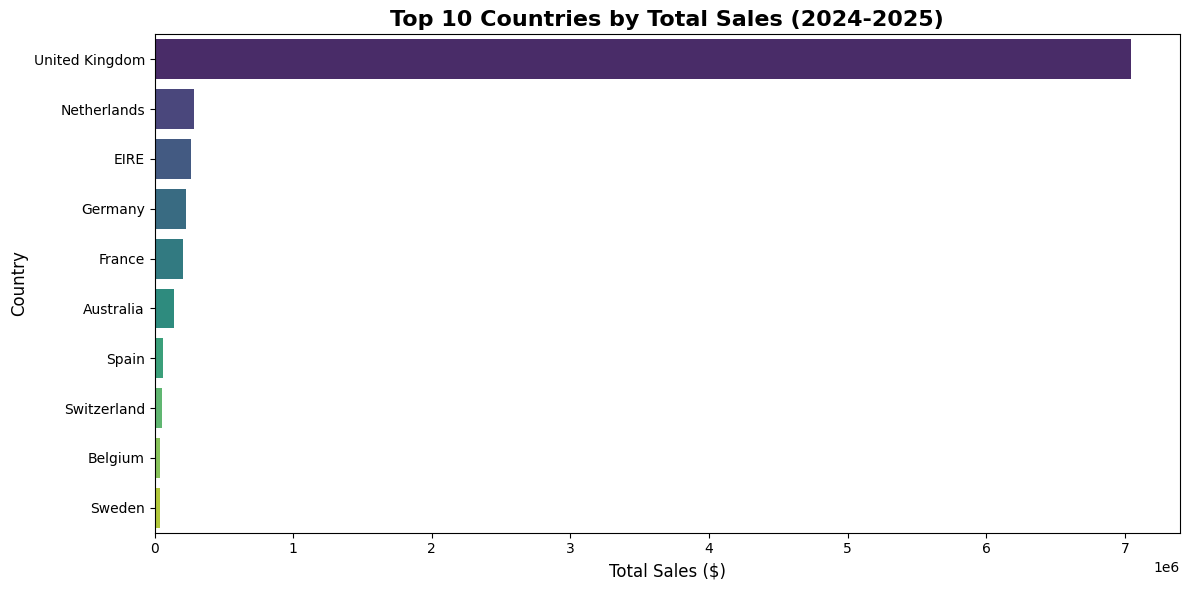

✓ Visualization saved to: c:\Users\Admin\Documents\GitHub\DSA-2040_Practical_Exam_Bophine_Arnold_Odiyo_821\sales_by_country.png


In [52]:
def visualize_data():
    """Task 3.2: Visualize Results"""
    print(f"\n--- VISUALIZATION PHASE ---")
    conn = sqlite3.connect(DB_FILE)
    
    # Query: Total Sales by Country (Top 10)
    query = """
    SELECT 
        c.country,
        SUM(f.total_sales) as total_sales
    FROM SalesFact f
    JOIN CustomerDim c ON f.customer_id = c.customer_id
    GROUP BY c.country
    ORDER BY total_sales DESC
    LIMIT 10;
    """
    
    try:
        df_viz = pd.read_sql_query(query, conn)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df_viz, x='total_sales', y='country', hue='country', palette='viridis', legend=False)
        plt.title('Top 10 Countries by Total Sales (2024-2025)', fontsize=16, fontweight='bold')
        plt.xlabel('Total Sales ($)', fontsize=12)
        plt.ylabel('Country', fontsize=12)
        plt.tight_layout()
        
        output_path = os.path.join(BASE_DIR, 'sales_by_country.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Visualization saved to: {output_path}")
        
    except Exception as e:
        print(f"✗ Error visualizing data: {e}")
    finally:
        conn.close()

# Generate visualization
visualize_data()